# Time series forecasting

In [1]:
#!pip install pystan==2.19.1.1

In [3]:
#!pip install prophet

In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from datetime import date
import holidays

# The data

This is a literal excerpt form the Kaggle data description found at https://www.kaggle.com/c/store-sales-time-series-forecasting

In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

### File Descriptions and Data Field Information

#### train.csv
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

#### test.csv
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

#### sample_submission.csv
- A sample submission file in the correct format.

#### stores.csv
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

#### oil.csv
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### holidays_events.csv
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

#### Additional Notes
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## Loading the data

In [5]:
Store_df = pd.read_csv("store-sales-time-series-forecasting/train.csv")
Store_df['date']= pd.to_datetime(Store_df['date'])
Store_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
all_shop_total = Store_df.groupby(by=['date']).sum() 
all_shop_total= all_shop_total.reset_index()  
all_shop_total.head()

,date,id,store_nbr,sales,onpromotion
0,2013-01-01,1586871,49005,2511.618999,0
1,2013-01-02,4762395,49005,496092.417944,0
2,2013-01-03,7937919,49005,361461.231124,0
3,2013-01-04,11113443,49005,354459.677093,0
4,2013-01-05,14288967,49005,477350.121229,0


<AxesSubplot:xlabel='date', ylabel='sales'>

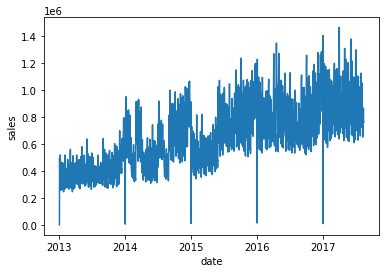

In [7]:
sns.lineplot(x="date", y="sales", data=all_shop_total)

In [8]:
all_shop_family = Store_df.groupby(by=['date', 'family']).sum() 
all_shop_family= all_shop_family.reset_index()  
all_shop_family.head()

,date,family,id,store_nbr,sales,onpromotion
0,2013-01-01,AUTOMOTIVE,47223,1485,0.0,0
1,2013-01-01,BABY CARE,47277,1485,0.0,0
2,2013-01-01,BEAUTY,47331,1485,2.0,0
3,2013-01-01,BEVERAGES,47385,1485,810.0,0
4,2013-01-01,BOOKS,47439,1485,0.0,0


<AxesSubplot:xlabel='date', ylabel='sales'>

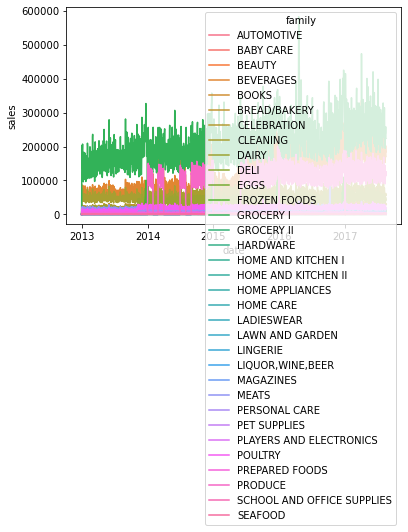

In [9]:
sns.lineplot(x="date", y="sales", hue = 'family',data=all_shop_family)

### Selecting a category of interest

<AxesSubplot:xlabel='date', ylabel='sales'>

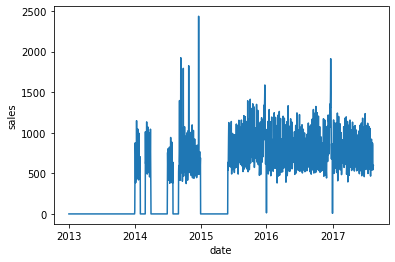

In [10]:


all_shop_family_subset  = all_shop_family[all_shop_family['family'].isin(['CELEBRATION']) ] 
sns.lineplot(x="date", y="sales",data=all_shop_family_subset)

In [11]:
all_shop_family_subset.head()

,date,family,id,store_nbr,sales,onpromotion
6,2013-01-01,CELEBRATION,47547,1485,0.0,0
39,2013-01-02,CELEBRATION,143775,1485,0.0,0
72,2013-01-03,CELEBRATION,240003,1485,0.0,0
105,2013-01-04,CELEBRATION,336231,1485,0.0,0
138,2013-01-05,CELEBRATION,432459,1485,0.0,0


In [12]:
Celebration_Prophet_DF =  all_shop_family_subset[['date', 'sales']].copy()
Celebration_Prophet_DF.rename(columns={"date": "ds", "sales": "y"}, inplace = True)
Celebration_Prophet_DF

,ds,y
6,2013-01-01,0.0
39,2013-01-02,0.0
72,2013-01-03,0.0
105,2013-01-04,0.0
138,2013-01-05,0.0
...,...,...
55413,2017-08-11,870.0
55446,2017-08-12,849.0
55479,2017-08-13,544.0
55512,2017-08-14,594.0


In [16]:
Celebration_Prophet_DF['ds']

6       2013-01-01
39      2013-01-02
72      2013-01-03
105     2013-01-04
138     2013-01-05
           ...    
55413   2017-08-11
55446   2017-08-12
55479   2017-08-13
55512   2017-08-14
55545   2017-08-15
Name: ds, Length: 1684, dtype: datetime64[ns]

In [17]:
Celebration_Prophet_DF_train = Celebration_Prophet_DF[Celebration_Prophet_DF['ds'] <= "2016-12-20"]

In [18]:
Celebration_Prophet_DF_train.tail()

,ds,y
47592,2016-12-16,1064.0
47625,2016-12-17,1319.0
47658,2016-12-18,1355.0
47691,2016-12-19,1345.0
47724,2016-12-20,1304.0


## Prophet forecasting

In [19]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(Celebration_Prophet_DF_train)

01:17:53 - cmdstanpy - INFO - Chain [1] start processing
01:17:53 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
forecast_days = 14
future = m.make_future_dataframe(periods=forecast_days )
future

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
1456,2016-12-30
1457,2016-12-31
1458,2017-01-01
1459,2017-01-02


In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1456,2016-12-30,755.792590,467.638239,1030.529636
1457,2016-12-31,902.261354,610.668011,1199.182019
1458,2017-01-01,553.308341,278.641423,846.675266
1459,2017-01-02,432.267637,151.614580,702.840145
1460,2017-01-03,438.452634,148.581187,727.014319


In [22]:
forecast.loc[forecast['yhat'] <0, 'yhat'] = 0
forecast = forecast[forecast['ds'] > Celebration_Prophet_DF_train['ds'].max()  ]

In [23]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1447,2016-12-21,588.136716,482.612352,1073.274077,588.136716,588.136716,0.354090,0.354090,0.354090,-0.108140,-0.108140,-0.108140,0.462230,0.462230,0.462230,0.0,0.0,0.0,796.389934
1448,2016-12-22,587.156983,547.301507,1109.943588,587.156983,587.156983,0.384928,0.384928,0.384928,-0.052213,-0.052213,-0.052213,0.437141,0.437141,0.437141,0.0,0.0,0.0,813.170311
1449,2016-12-23,586.177250,634.404106,1217.051668,586.177250,586.177250,0.590381,0.590381,0.590381,0.182703,0.182703,0.182703,0.407678,0.407678,0.407678,0.0,0.0,0.0,932.245006
1450,2016-12-24,585.197517,781.318405,1352.159866,585.197517,585.197517,0.857196,0.857196,0.857196,0.482934,0.482934,0.482934,0.374262,0.374262,0.374262,0.0,0.0,0.0,1086.826495
1451,2016-12-25,584.217783,462.507738,1036.962534,584.217783,584.217783,0.262366,0.262366,0.262366,-0.075020,-0.075020,-0.075020,0.337386,0.337386,0.337386,0.0,0.0,0.0,737.496663
1452,2016-12-26,583.238050,321.997130,904.132029,583.238050,583.238050,0.056424,0.056424,0.056424,-0.241180,-0.241180,-0.241180,0.297604,0.297604,0.297604,0.0,0.0,0.0,616.146789
1453,2016-12-27,582.258317,329.651110,901.196701,582.258317,582.258317,0.066434,0.066434,0.066434,-0.189084,-0.189084,-0.189084,0.255518,0.255518,0.255518,0.0,0.0,0.0,620.939944
1454,2016-12-28,581.278584,334.997520,942.638304,581.278584,581.278584,0.103626,0.103626,0.103626,-0.108140,-0.108140,-0.108140,0.211766,0.211766,0.211766,0.0,0.0,0.0,641.514232
1455,2016-12-29,580.298851,383.390887,931.115729,580.298851,580.298851,0.114798,0.114798,0.114798,-0.052213,-0.052213,-0.052213,0.167010,0.167010,0.167010,0.0,0.0,0.0,646.915928
1456,2016-12-30,579.319117,467.638239,1030.529636,579.319117,579.319117,0.304622,0.304622,0.304622,0.182703,0.182703,0.182703,0.121919,0.121919,0.121919,0.0,0.0,0.0,755.792590


In [19]:
#fig1 = m.plot(forecast)

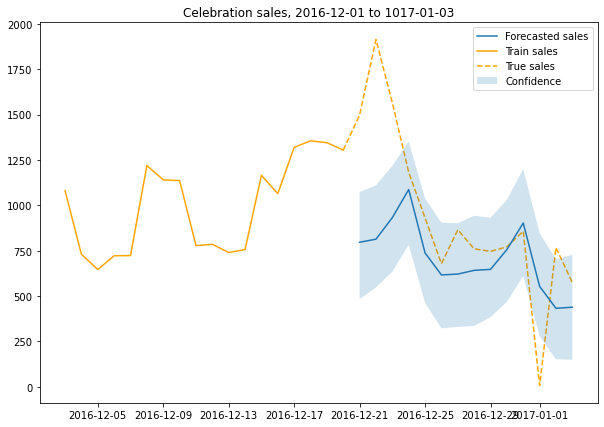

In [24]:
Celebration_Prophet_DF_train_plot = Celebration_Prophet_DF_train[Celebration_Prophet_DF_train['ds'] >= (forecast['ds'].max() - timedelta(days=31))]
Celebration_Prophet_DF_truth = Celebration_Prophet_DF[np.logical_and(Celebration_Prophet_DF['ds'] >= Celebration_Prophet_DF_train_plot['ds'].max(),Celebration_Prophet_DF['ds'] <= forecast['ds'].max()  ) ]

plt.figure(figsize = (10,7))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted sales', zorder = 1)
plt.plot(Celebration_Prophet_DF_train_plot['ds'], Celebration_Prophet_DF_train_plot['y'], label='Train sales', zorder = 0, color = 'orange')                                                                                       
plt.plot(Celebration_Prophet_DF_truth['ds'], Celebration_Prophet_DF_truth['y'], label='True sales', zorder = 0, color = 'orange', linestyle='dashed')
plt.fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'],
                 alpha=.2, label='Confidence')
plt.title('Celebration sales, 2016-12-01 to 1017-01-03')
plt.legend()
#plt.savefig('prophet_forecast.png')
plt.show()



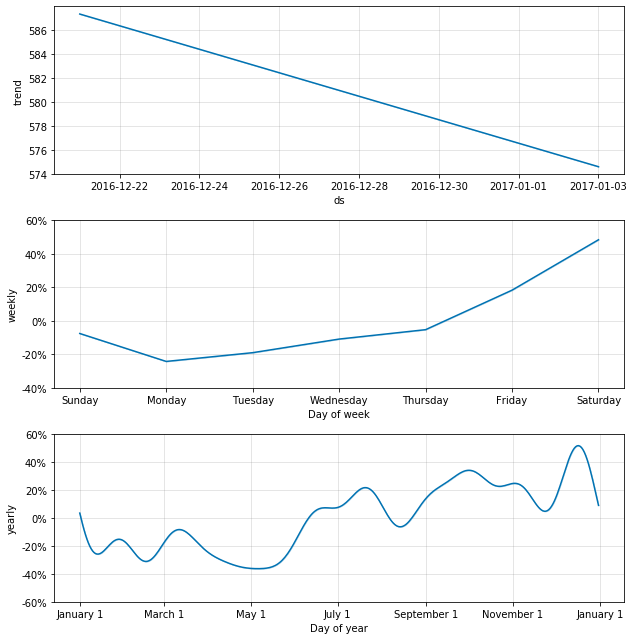

In [21]:
fig2 = m.plot_components(forecast)

## including holidays

In [22]:
holidays_national_local = pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv")
holidays_national_local

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [23]:
holidays_national =holidays_national_local[holidays_national_local['locale'] == 'National' ].copy()
holidays_national

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [24]:
#for index, row in new_year_df_cleaned.iterrows():
    
    
#    for days_diff in range(1,4):
#        if str(row["ds"].date() - timedelta(days=days_diff) ) in new_year_df['ds'].dt.strftime('%Y-%m-%d').values:
#            new_year_df_cleaned.loc[index,'lower_window'] -= 1
            
#        if str(row["ds"].date() + timedelta(days=days_diff) ) in new_year_df['ds'].dt.strftime('%Y-%m-%d').values:
#            new_year_df_cleaned.loc[index,'upper_window'] += 1    
        



#print( row["ds"].date() )
    #print( str(row["ds"].date() - timedelta(days=1) ) in new_year_df['ds'].dt.strftime('%Y-%m-%d').values )
    #print( str(row["ds"].date() - timedelta(days=1) )  )    

In [25]:
all_holidays = holidays_national[['description', 'date'] ].copy()
all_holidays.rename(columns={"description": "holiday", "date": "ds"}, inplace = True)
all_holidays['lower_window'] = 0
all_holidays['upper_window'] = 0
all_holidays

,holiday,ds,lower_window,upper_window
14,Primer Grito de Independencia,2012-08-10,0,0
19,Independencia de Guayaquil,2012-10-09,0,0
20,Traslado Independencia de Guayaquil,2012-10-12,0,0
21,Dia de Difuntos,2012-11-02,0,0
22,Independencia de Cuenca,2012-11-03,0,0
...,...,...,...,...
345,Navidad-3,2017-12-22,0,0
346,Navidad-2,2017-12-23,0,0
347,Navidad-1,2017-12-24,0,0
348,Navidad,2017-12-25,0,0


## Training a model with holidays

In [26]:
m = Prophet(holidays=all_holidays, seasonality_mode='multiplicative')
m.fit(Celebration_Prophet_DF_train)

forecast_days = 14
future = m.make_future_dataframe(periods=forecast_days )
future

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.loc[forecast['yhat'] <0, 'yhat'] = 0
forecast = forecast[forecast['ds'] > Celebration_Prophet_DF_train['ds'].max()  ]
forecast.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Batalla de Pichincha,Batalla de Pichincha_lower,Batalla de Pichincha_upper,Black Friday,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1456,2016-12-30,608.500993,625.289675,1135.427622,608.500993,608.500993,0.0,0.0,0.0,0.0,...,0.211854,0.211854,0.211854,0.225159,0.225159,0.225159,0.0,0.0,0.0,874.423488
1457,2016-12-31,607.981640,853.625346,1375.388632,607.981640,607.981640,0.0,0.0,0.0,0.0,...,0.517659,0.517659,0.517659,0.189117,0.189117,0.189117,0.0,0.0,0.0,1131.120793
1458,2017-01-01,607.462287,-342.165383,181.526147,607.462287,607.462287,0.0,0.0,0.0,0.0,...,-0.079354,-0.079354,-0.079354,0.153810,0.153810,0.153810,0.0,0.0,0.0,0.000000
1459,2017-01-02,606.942934,235.550549,771.970328,606.868098,606.942934,0.0,0.0,0.0,0.0,...,-0.272300,-0.272300,-0.272300,0.119776,0.119776,0.119776,0.0,0.0,0.0,514.369558
1460,2017-01-03,606.423581,280.297375,797.859127,606.158167,606.479225,0.0,0.0,0.0,0.0,...,-0.205979,-0.205979,-0.205979,0.087513,0.087513,0.087513,0.0,0.0,0.0,534.582810


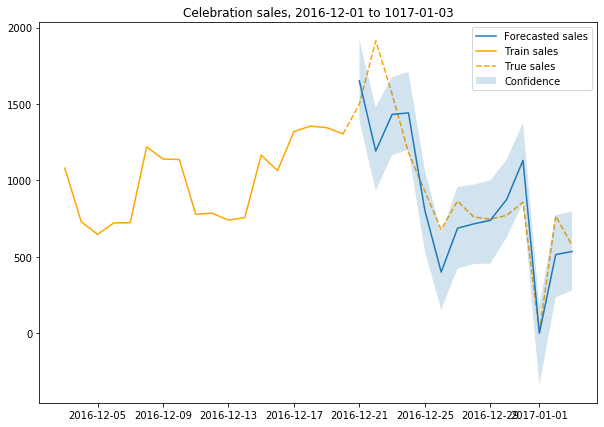

In [27]:
Celebration_Prophet_DF_train_plot = Celebration_Prophet_DF_train[Celebration_Prophet_DF_train['ds'] >= (forecast['ds'].max() - timedelta(days=31))]
Celebration_Prophet_DF_truth = Celebration_Prophet_DF[np.logical_and(Celebration_Prophet_DF['ds'] >= Celebration_Prophet_DF_train_plot['ds'].max(),Celebration_Prophet_DF['ds'] <= forecast['ds'].max()  ) ]

plt.figure(figsize = (10,7))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted sales', zorder = 1)
plt.plot(Celebration_Prophet_DF_train_plot['ds'], Celebration_Prophet_DF_train_plot['y'], label='Train sales', zorder = 0, color = 'orange')                                                                                       
plt.plot(Celebration_Prophet_DF_truth['ds'], Celebration_Prophet_DF_truth['y'], label='True sales', zorder = 0, color = 'orange', linestyle='dashed')
plt.fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'],
                 alpha=.2, label='Confidence')
plt.title('Celebration sales, 2016-12-01 to 1017-01-03')
plt.legend()
#plt.savefig('prophet_forecast.png')
plt.show()

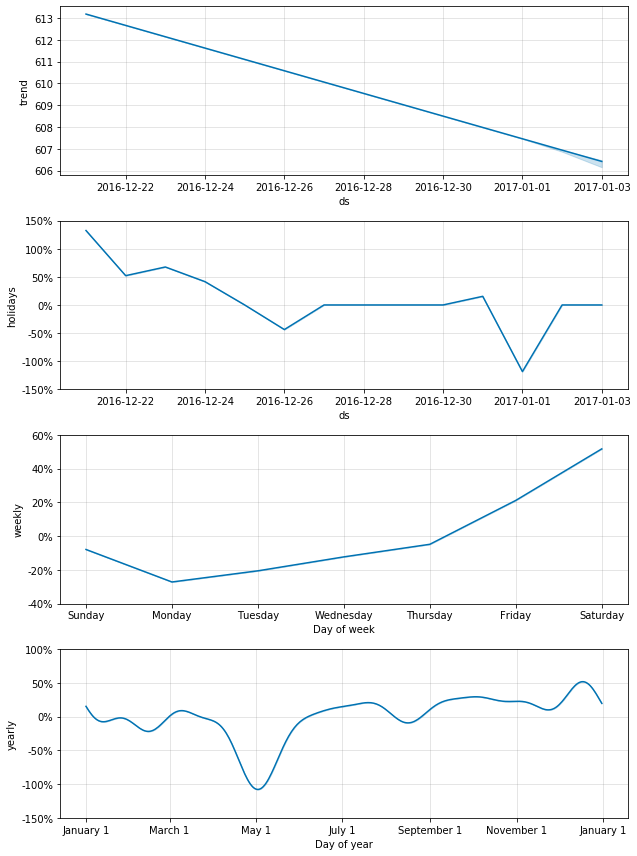

In [28]:
fig2 = m.plot_components(forecast)

In [29]:
forecasting_result = forecast.merge(Celebration_Prophet_DF_truth, how='inner', on='ds')
forecasting_result

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Batalla de Pichincha,Batalla de Pichincha_lower,Batalla de Pichincha_upper,Black Friday,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
0,2016-12-21,613.175171,1394.187991,1921.093084,613.175171,613.175171,0.0,0.0,0.0,0.0,...,-0.123283,-0.123283,0.490030,0.490030,0.490030,0.0,0.0,0.0,1650.681313,1498.0
1,2016-12-22,612.655818,931.835139,1478.663360,612.655818,612.655818,0.0,0.0,0.0,0.0,...,-0.048597,-0.048597,0.471996,0.471996,0.471996,0.0,0.0,0.0,1191.594200,1913.0
2,2016-12-23,612.136465,1165.939644,1675.979754,612.136465,612.136465,0.0,0.0,0.0,0.0,...,0.211854,0.211854,0.450124,0.450124,0.450124,0.0,0.0,0.0,1431.136699,1565.0
3,2016-12-24,611.617112,1199.531967,1709.676538,611.617112,611.617112,0.0,0.0,0.0,0.0,...,0.517659,0.517659,0.424752,0.424752,0.424752,0.0,0.0,0.0,1441.539729,1182.0
4,2016-12-26,610.578406,154.511215,657.272121,610.578406,610.578406,0.0,0.0,0.0,0.0,...,-0.272300,-0.272300,0.365181,0.365181,0.365181,0.0,0.0,0.0,399.789610,678.0
5,2016-12-27,610.059053,421.293256,957.238257,610.059053,610.059053,0.0,0.0,0.0,0.0,...,-0.205979,-0.205979,0.331957,0.331957,0.331957,0.0,0.0,0.0,686.913408,865.0
6,2016-12-28,609.539699,453.347968,972.194521,609.539699,609.539699,0.0,0.0,0.0,0.0,...,-0.123283,-0.123283,0.297162,0.297162,0.297162,0.0,0.0,0.0,715.526161,760.0
7,2016-12-29,609.020346,455.049295,1000.338290,609.020346,609.020346,0.0,0.0,0.0,0.0,...,-0.048597,-0.048597,0.261368,0.261368,0.261368,0.0,0.0,0.0,738.601875,746.0
8,2016-12-30,608.500993,625.289675,1135.427622,608.500993,608.500993,0.0,0.0,0.0,0.0,...,0.211854,0.211854,0.225159,0.225159,0.225159,0.0,0.0,0.0,874.423488,771.0
9,2016-12-31,607.981640,853.625346,1375.388632,607.981640,607.981640,0.0,0.0,0.0,0.0,...,0.517659,0.517659,0.189117,0.189117,0.189117,0.0,0.0,0.0,1131.120793,857.0
